In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
import requests
import time
import json
import re

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analyzing, and Visualizing Data

In [34]:
df = pd.read_csv('twitter_archive_master.csv')

In [35]:
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorites,retweets,user_followers,jpg_url,dogs_stage,pred_algo,conf_level,rating
0,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689...,12.0,10,NaN,298,82,8653672,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,None,Rottweiler,0.999091,1.2
1,667437278097252352,2015-11-19 20:20:22,Twitter for iPhone,Never seen this breed before. Very pointy pup....,https://twitter.com/dog_rates/status/667437278...,10.0,10,NaN,437,227,8653672,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,None,NaN,0.000000,1.0
2,667443425659232256,2015-11-19 20:44:47,Twitter for iPhone,Exotic dog here. Long neck. Weird paws. Obsess...,https://twitter.com/dog_rates/status/667443425...,6.0,10,NaN,756,555,8653672,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,None,NaN,0.000000,0.6
3,667453023279554560,2015-11-19 21:22:56,Twitter Web Client,Meet Cupcake. I would do unspeakable things fo...,https://twitter.com/dog_rates/status/667453023...,11.0,10,Cupcake,297,85,8653672,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,None,Labrador_retriever,0.825670,1.1
4,667455448082227200,2015-11-19 21:32:34,Twitter Web Client,This is Reese and Twips. Reese protects Twips....,https://twitter.com/dog_rates/status/667455448...,7.0,10,Reese,184,57,8653672,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg,None,Tibetan_terrier,0.676376,0.7


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 16 columns):
tweet_id              1987 non-null int64
timestamp             1987 non-null object
source                1987 non-null object
text                  1987 non-null object
expanded_urls         1987 non-null object
rating_numerator      1987 non-null float64
rating_denominator    1987 non-null int64
name                  1343 non-null object
favorites             1987 non-null int64
retweets              1987 non-null int64
user_followers        1987 non-null int64
jpg_url               1987 non-null object
dogs_stage            1987 non-null object
pred_algo             1679 non-null object
conf_level            1987 non-null float64
rating                1987 non-null float64
dtypes: float64(3), int64(5), object(8)
memory usage: 248.5+ KB


In [37]:
# Convert columns to their appropriate types and set the timestamp as an index

df['tweet_id'] = df['tweet_id'].astype(object)
df['timestamp'] = pd.to_datetime(df.timestamp)
df['source'] = df['source'].astype('category')
df['dogs_stage'] = df['dogs_stage'].astype('category')

df.set_index('timestamp', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1987 entries, 2015-11-19 20:14:03 to 2016-06-03 01:07:16
Data columns (total 15 columns):
tweet_id              1987 non-null object
source                1987 non-null category
text                  1987 non-null object
expanded_urls         1987 non-null object
rating_numerator      1987 non-null float64
rating_denominator    1987 non-null int64
name                  1343 non-null object
favorites             1987 non-null int64
retweets              1987 non-null int64
user_followers        1987 non-null int64
jpg_url               1987 non-null object
dogs_stage            1987 non-null category
pred_algo             1679 non-null object
conf_level            1987 non-null float64
rating                1987 non-null float64
dtypes: category(2), float64(3), int64(4), object(6)
memory usage: 221.5+ KB


In [38]:
df.describe()

,rating_numerator,rating_denominator,favorites,retweets,user_followers,conf_level,rating
count,1987.000000,1987.000000,1987.000000,1987.000000,1.987000e+03,1987.000000,1987.000000
mean,12.236930,10.533971,8374.622547,2489.725717,8.653639e+06,0.463913,1.164651
std,41.544174,7.333532,12323.848862,4454.209864,6.494713e+01,0.339364,4.071452
min,0.000000,2.000000,72.000000,11.000000,8.653588e+06,0.000000,0.000000
25%,10.000000,10.000000,1799.500000,557.000000,8.653598e+06,0.140041,1.000000
50%,11.000000,10.000000,3791.000000,1206.000000,8.653640e+06,0.457356,1.100000
75%,12.000000,10.000000,10426.500000,2829.000000,8.653670e+06,0.776138,1.200000
max,1776.000000,170.000000,158288.000000,78873.000000,8.654331e+06,0.999956,177.600000


### 1. Plotting the correlation map to see the relationship between variables

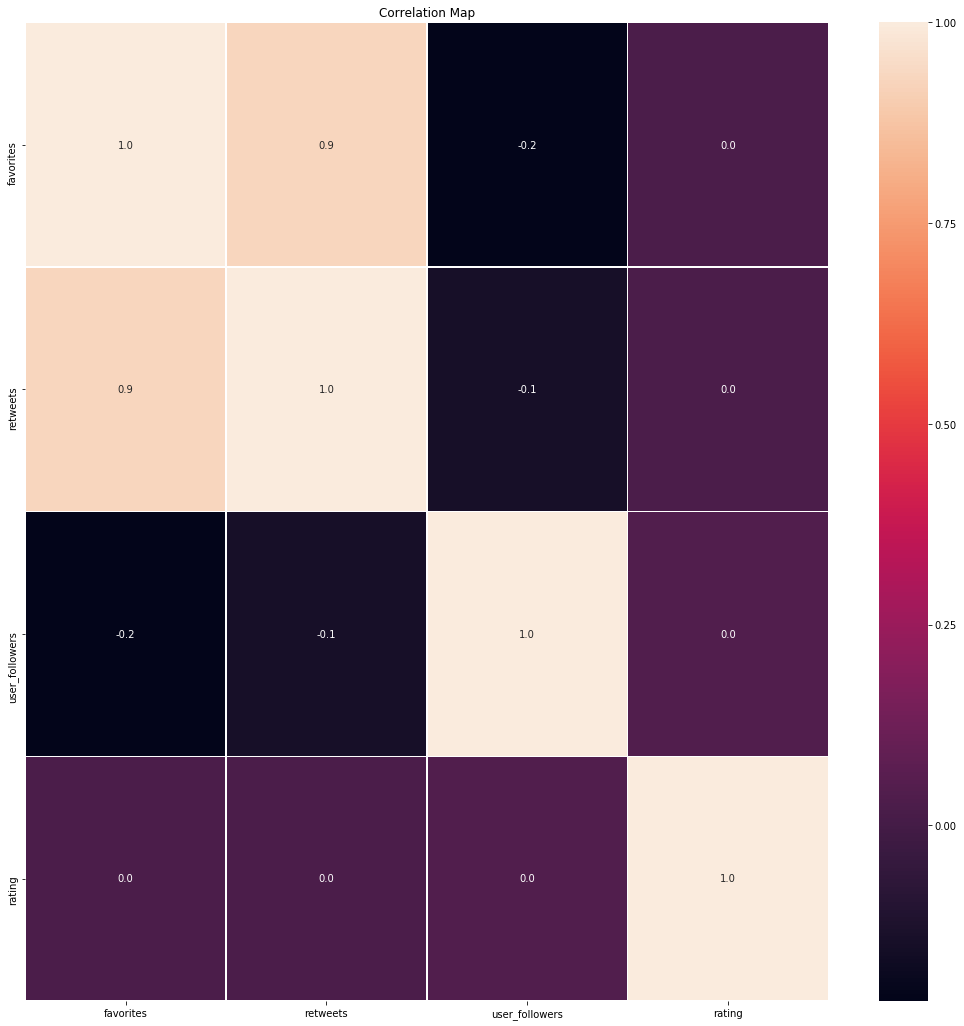

In [39]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df[['source', 'favorites','retweets',
                'user_followers','rating']].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation Map');


    ### The only strong correlation we see here is between favorites and retweet, this is normal (more favorites mean more retweets).
       
    ### User followers and retweet have a weak negative correlation of -0.1 (this seems the opposite of normal prediction)

### 2. Finding which dog type is most common

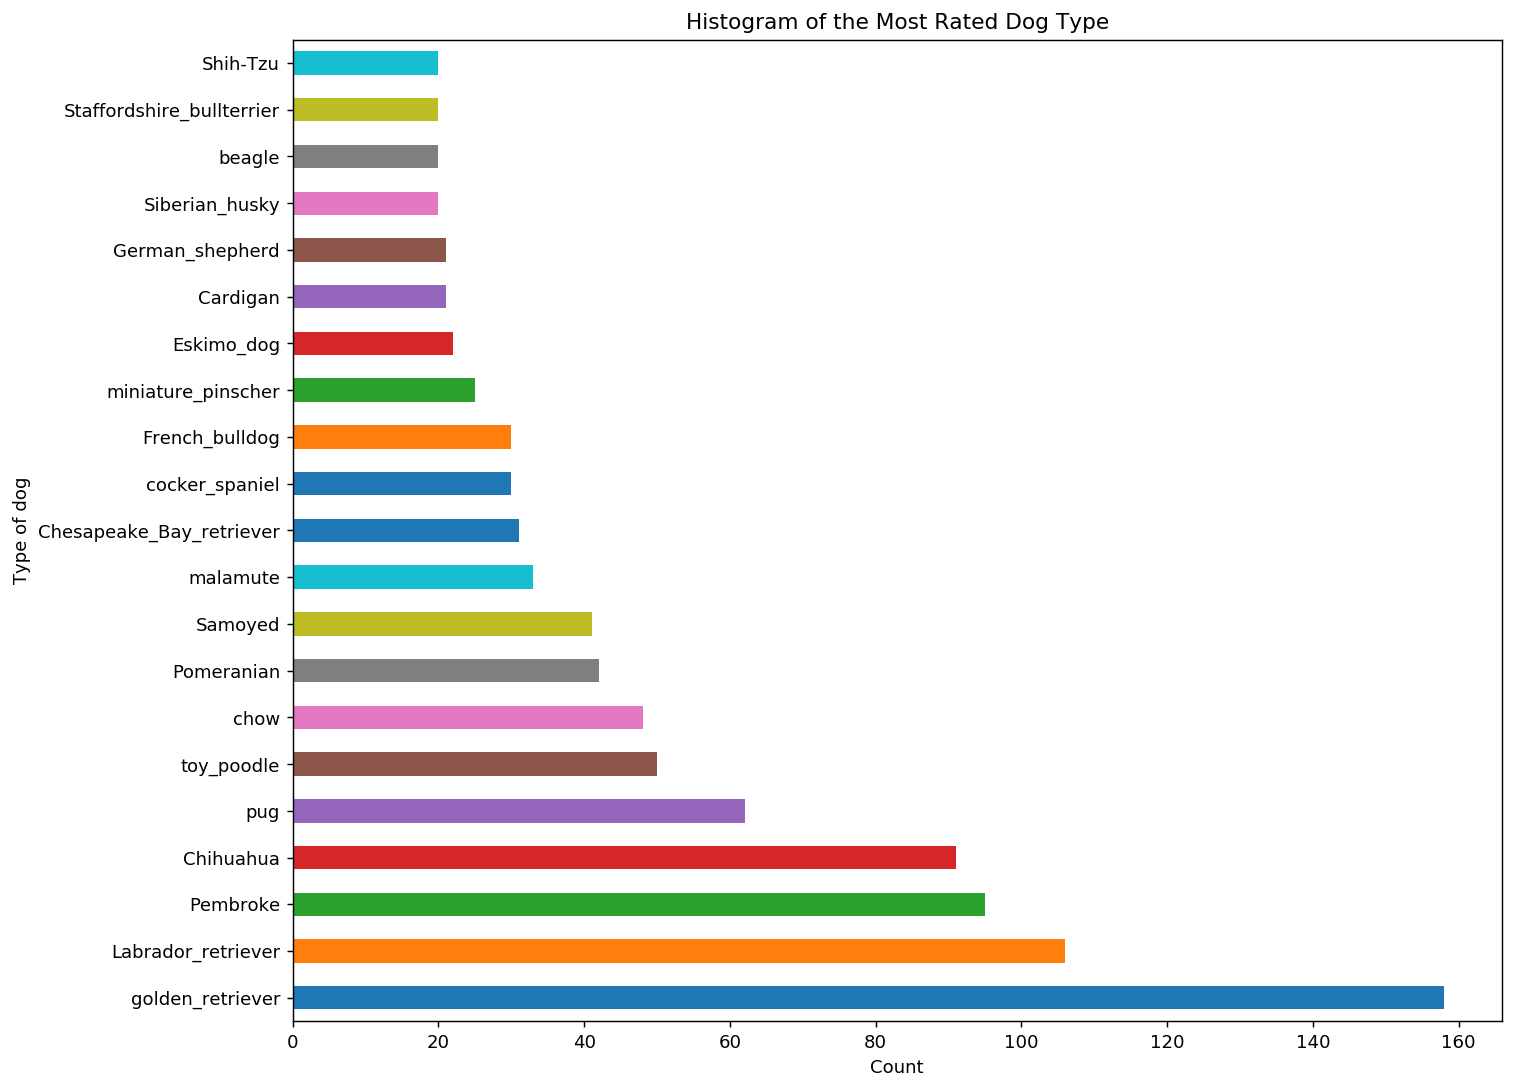

In [40]:
dog_type = df.groupby('pred_algo').filter(lambda x: len(x) >= 20)

plt.figure(figsize=(12,10), dpi = 130)

dog_type['pred_algo'].value_counts().plot(kind = 'barh')
plt.title('Histogram of the Most Rated Dog Type')
plt.xlabel('Count')
plt.ylabel('Type of dog');

       ###  Golden retriever is the most common dog.
       
       
### 3. Which dog type got lowest rating

In [41]:
dog_rating = df.groupby('pred_algo').mean()
dog_rating['rating']. sort_values()

pred_algo
Japanese_spaniel               0.500000
soft-coated_wheaten_terrier    0.880000
Scotch_terrier                 0.900000
Walker_hound                   0.900000
Tibetan_terrier                0.925000
dalmatian                      0.933333
Boston_bull                    0.941667
Welsh_springer_spaniel         0.950000
Maltese_dog                    0.952632
Dandie_Dinmont                 0.957143
miniature_schnauzer            0.960000
Norwich_terrier                0.960000
redbone                        0.966667
Afghan_hound                   0.966667
Rhodesian_ridgeback            0.975000
Scottish_deerhound             0.975000
Great_Dane                     0.981818
Airedale                       0.983333
Mexican_hairless               0.985714
Saint_Bernard                  0.985714
Newfoundland                   0.985714
miniature_poodle               0.987500
English_setter                 0.987500
miniature_pinscher             1.000000
Brabancon_griffon             

    ###   Japanese_spaniel has lowest rating among diffrent dog types
    
    
### 4. Finding is there a correlation between retweets and favorites

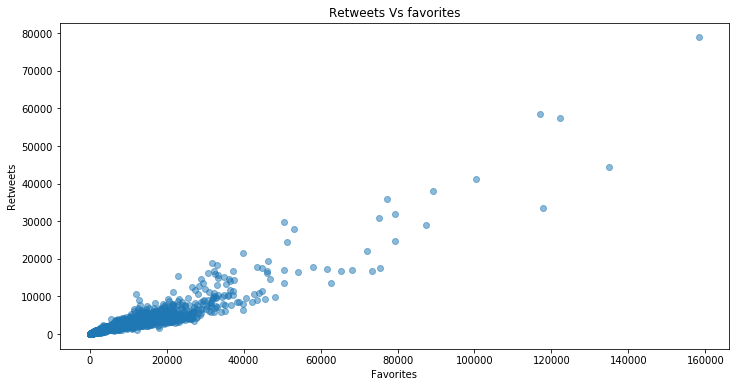

In [42]:
plt.figure(figsize=(12,6))
plt.scatter(x = df['favorites'],y = df['retweets'], alpha = 0.5)
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets Vs favorites');

    ### As the correlation map shows that retweet is high correlated with favorites.

### 5. Plot the data partitioned by dog stage

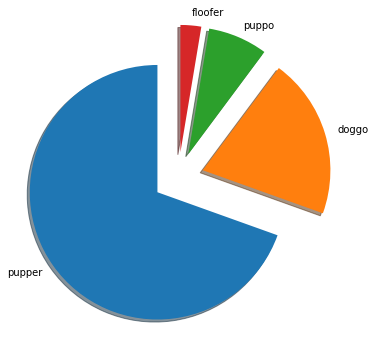

In [43]:
dog_breed_count = list(df[df['dogs_stage'] != 'None']['dogs_stage'].value_counts())[0:4]
dogs_breeds = df[df['dogs_stage'] != 'None']['dogs_stage'].value_counts().index.tolist()[0:4]
explode = (0.2, 0.2, 0.2, 0.2) 

f, ax = plt.subplots(figsize = (6,6))
ax.pie(dog_breed_count, explode = explode, labels = dogs_breeds, shadow = True, startangle = 90)
ax.axis('equal');

    ### Pupper is the most owned dog,but it has the lowest mean rating


### Insights:

* The most popular dog type is a "pupper"
* The most popular dog, based on image predictions, is a Golden Retriever
* Japanese_spaniel has lowest rating among diffrent dog types
* Pupper is the most owned dog,but it has the lowest mean rating
* As the correlation map shows that retweet is high correlated with favorites.